# Minicourse of Bayesian Machine Learning for Scientific Research
## Lecture 1

This notebook contains problems and discussions for the course.  We want you to pay attention and participate in the lectures, this is why, on-purpose, notebooks are not self-contained.  It has many comments that should be uncommented and tested, etc.  And many important comments are discussed in the lectures.

This notebook if intended solely for the Minicourse of Bayesian Machine Learning for Scientific Research.  Ezequiel Alvarez (sequialvz@gmail.com)

#### Setup

In [1]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

## Gaussian Mixtures

In many scientific research analyses one has a mixture of components: the sought signal and some background(s).  This first very simple example intends to give a first step in that direction.  These systems are called Mixture Models and are very important in scientific research.

### Generate data

In [25]:
# Create data sampled from a mixture of gaussians
# define the parameters
np.random.seed(5)
mu0 = 165
sigma0 = 8
mu1 = 185
sigma1 = 10
p = 0.5 # mixture parameter
#sampling
out = []
bernoulli = np.random.binomial(1, p, size=100)
for i in range(len(bernoulli)):
    if bernoulli[i] == 1:
        out.append(np.random.normal(mu0,sigma0))
    else:
        out.append(np.random.normal(mu1,sigma1))

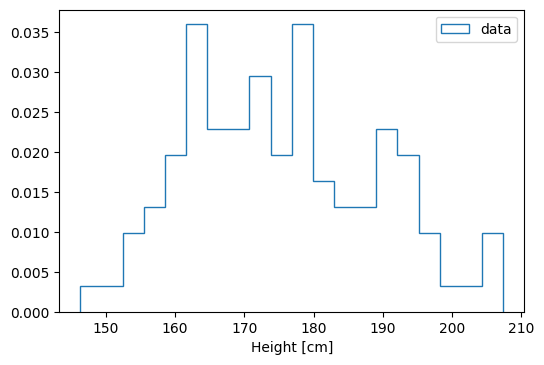

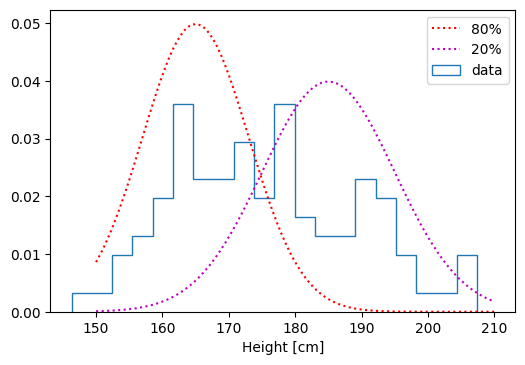

In [26]:
# We plot the data without labels (as we would actually see it!)
x=np.linspace(-150,210,100)
plt.hist(out, histtype='step', bins=20, density=1, label='data')
#plt.plot(x, stats.norm.pdf(x,mu0,sigma0), 'r:', label='80%')
#plt.plot(x, stats.norm.pdf(x,mu1,sigma1), 'm:', label='20%')
plt.xlabel('Height [cm]')
plt.legend()
plt.show()

# We plot the data without labels (as we would actually see it!)
x=np.linspace(150,210,100)
plt.hist(out, histtype='step', bins=20, density=1, label='data')
plt.plot(x, stats.norm.pdf(x,mu0,sigma0), 'r:', label='80%')
plt.plot(x, stats.norm.pdf(x,mu1,sigma1), 'm:', label='20%')
plt.xlabel('Height [cm]')
plt.legend()
plt.show()

### Implementing the Gaussian Mixture model

In [27]:
my_mixture="""
data {
 int <lower=0> N;
 vector[N] y;
}

parameters {
  ordered[2] mu;  // This tells the sampler that always mu[1] < mu[2]
  //real mu[2];   // Study what happens if we use this line instead of the above  (it is called 'label switching')
  real<lower=0> sigma[2];
  real<lower=0, upper=1> theta;
}

model {   
 sigma ~ cauchy(0, 10);  
 mu[1] ~ normal(160, 10);
 mu[2] ~ normal(170, 10);
 theta ~ beta(1, 1);  //this is a uniform flat distribution for p in (0,1)
 for (n in 1:N)
   target += log_mix(theta,
                     normal_lpdf(y[n] | mu[1], sigma[1]),
                     normal_lpdf(y[n] | mu[2], sigma[2]));
}
"""

In [28]:
my_data={'N':len(out),'y':out}

In [29]:
model = stan.build(my_mixture, data=my_data, random_seed=1);

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_vyv0alw6/model_n5sby7vx.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_vyv0alw6/model_n5sby7vx.stan', line 18, column 1: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Warning in '/tmp/httpstan_vyv0alw6/model_n5sby7vx.stan', line 17, column 16: Argument
    170 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_vyv0alw6/model_n5sby7vx.stan', line 16, column 16: Argument
    160 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [30]:
fit = model.sample(num_chains=4, num_samples=1000)
#fit = model.sample(num_chains=4, num_samples=1000, delta=0.95)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   4% (302/8000)
Sampling:  14% (1102/8000)
Sampling:  39% (3101/8000)
Sampling:  64% (5100/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!


In [31]:
df = fit.to_frame() 

In [32]:
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,sigma.1,sigma.2,theta
draws,,,,,,,,,,,,
0,-402.768884,0.853435,0.187881,2.0,3.0,0.0,404.164967,164.380705,178.497186,14.763057,12.930157,0.065253
1,-400.105307,0.986022,0.145262,5.0,31.0,0.0,401.343515,169.823244,182.862906,9.570139,15.875280,0.568317
2,-400.698920,0.886269,0.178403,4.0,15.0,0.0,405.055661,163.985399,180.645943,7.108867,15.868785,0.439656
3,-401.157037,0.928303,0.281754,4.0,15.0,0.0,403.200809,160.757627,177.916096,6.602992,11.050533,0.111242
4,-399.557204,0.918881,0.187881,4.0,23.0,0.0,407.017445,167.278439,178.100805,11.426926,13.312994,0.374132
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-400.479349,0.818053,0.281754,3.0,11.0,0.0,405.468832,162.902185,179.334209,5.335784,13.686128,0.074726
3996,-401.322095,0.972090,0.187881,3.0,7.0,0.0,401.844724,162.480358,176.163009,0.904626,12.245293,0.041691
3997,-400.593689,0.460956,0.145262,3.0,11.0,0.0,405.119165,162.621076,178.661461,8.225606,12.251304,0.438624


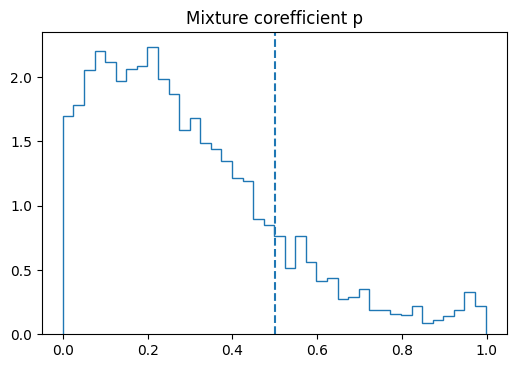

In [33]:
plt.hist(df['theta'], histtype='step', density=1, bins=40)
plt.axvline(x=p, linestyle='dashed')
#plt.axvline(x=1-p, linestyle='dashed')
plt.title('Mixture corefficient p')
plt.show()

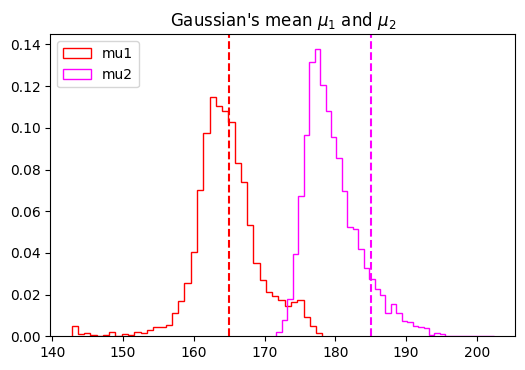

In [34]:
plt.hist(df['mu.1'],histtype='step', bins=40, color='red', density=1, label='mu1')
plt.hist(df['mu.2'],histtype='step', bins=40, color='magenta', density=1, label='mu2')
plt.axvline(x=mu0, linestyle='dashed', color='red')
plt.axvline(x=mu1, linestyle='dashed', color='magenta')
plt.title("Gaussian's mean $\mu_1$ and $\mu_2$")
plt.legend()
plt.show()

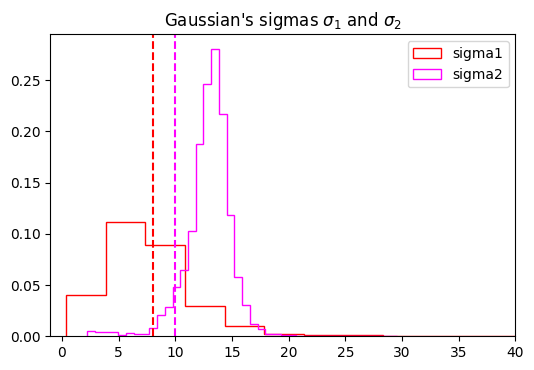

In [39]:
plt.hist(df['sigma.1'],histtype='step', bins=60, color='red', density=1, label='sigma1')
plt.hist(df['sigma.2'],histtype='step', bins=40, color='magenta', density=1, label='sigma2')
plt.axvline(x=sigma0, linestyle='dashed', color='red')
plt.axvline(x=sigma1, linestyle='dashed', color='magenta')
plt.title("Gaussian's sigmas $\sigma_1$ and $\sigma_2$")
plt.xlim(-1,40)
plt.legend()
plt.show()

### Let's study the sampling

In [36]:
azdata = az.from_pystan(fit)

In [37]:
summary = az.summary(azdata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],164.649,4.637,158.147,175.282,0.246,0.174,451.0,387.0,1.01
mu[1],179.643,3.901,173.145,187.094,0.134,0.095,839.0,1349.0,1.00
sigma[0],7.885,6.726,0.575,14.149,0.220,0.155,655.0,799.0,1.00
sigma[1],12.951,2.077,9.214,16.560,0.100,0.071,701.0,408.0,1.00
theta,0.293,0.215,0.000,0.695,0.009,0.007,539.0,470.0,1.00


In [62]:
azdata.posterior

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, mu_dim_0: 2, sigma_dim_0: 2)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * mu_dim_0     (mu_dim_0) int64 0 1
  * sigma_dim_0  (sigma_dim_0) int64 0 1
Data variables:
    mu           (chain, draw, mu_dim_0) float64 2.466 6.041 ... 1.855 5.039
    sigma        (chain, draw, sigma_dim_0) float64 1.805 0.6916 ... 1.565 1.209
    theta        (chain, draw) float64 0.9119 0.9171 0.8582 ... 0.7746 0.7824
Attributes:
    created_at:                 2024-09-15T22:14:39.875576
    arviz_version:              0.15.1
    inference_library:          stan
    inference_library_version:  3.7.0
    num_chains:                 4
    num_samples:                1000
    num_thin:                   1
    num_warmup:                 1000
    save_warmup:                0

## Some final observations:

- Mixture models are essential to science
- 'Logmix()' is a very useful function to add log-Likelihoods. Recall that exp(-300) is the smallest positive double() precision! <a href="https://db.apache.org/derby/docs/10.2/ref/rrefsqljdoubleprecision.html#:~:text=Smallest%20DOUBLE%20value%3A%20%2D1.79769E,DOUBLE%20value%3A%202.225E%2D307">(see link)</a>
- The 'target += ' method in the Stan model block is very clear: we are constructing the Likelihood event-by-event
- But there are other models as well!
- Play with ordered_vector
- Play with verifying Rhat is close enough to 1 to trust your sampling
- Play with some sampling control variables such as delta